# BS_CFP_singleCond_v1

#### This note book is designed with the same spatial and hydrological parameters as the BS_CFP_v1 model, except that the model here has a single, straight conduit built in and does NOT use pyKasso to simulate the conduit network based off from geologic field data

## Import packages necessary to run CFPy, flopy

In [95]:
##Import package dependencies
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import glob

import CFPy as cfpy
import flopy as flopy
path=""

## Show Versions w/ line magic
Show the versions of python and the imported packages being used in this model

In [96]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [97]:
%watermark

Last updated: 2023-04-12T12:48:36.650803-05:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.10.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 13, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [98]:
%watermark --iversions

CFPy      : 0.1
flopy     : 3.3.6
numpy     : 1.24.2
matplotlib: 3.7.0
pandas    : 1.5.3



In [99]:
##Define helper functions
def position_to_index(x, y):
    """
    Get the modflow (!) based index for a given geo position
    
    Keyword Arguments
    x -- x position, m
    y -- y position, m
    
    Return
    column index, row index
    """
    
    col_idx = np.floor(x / delr) + 1
    row_idx = n_rows - np.floor(y / delc)
    
    return col_idx, row_idx

def store_results(number):
    """
    Create a directory and put the current results there
    
    Keyword Arguments
    number -- identifier of the current iteration, float or int
    
    Return
    -
    """
    
    # define directory where to store the results
    target_dir = os.path.join(path, f"run_{number}")
    
    # make sure the directory does not exist
    if os.path.exists(target_dir):
        raise Exception(f"Directory {target_dir} exists already! Unable to write results")
        
    # create directory
    os.makedirs(target_dir)
    
    # get alle files that will be moved
    files_to_move = glob.glob("NODE*") + glob.glob("TUBE*") \
                    + [f"{modelname}.list", f"{modelname}.hds", f"{modelname}.cbc"] \
                    + [f"network_{number}.png"] \
                    + glob.glob("*.nbr") + glob.glob("*.coc") + glob.glob("*.cfp") + glob.glob("*.crch")
    
    # move files to directory
    for f in files_to_move:
        source = os.path.join(path, f)
        destination = os.path.join(target_dir, f)
        shutil.move(source, destination)

def clean_results():
    """
    Remove all run-dictionaries
    
    Keyword Arguments
    -
    
    Return
    -
    """    
    run_dirs = glob.glob(os.path.join(path, "run_*"))    
    for rd in run_dirs:
        shutil.rmtree(rd)
        
def plot_network(valid_network, number):
    """
    Plot and save valid network array as png
    
    Keyword Arguments
    valid_network -- valid network array
    number -- identifier of the current iteration, float or int
    
    Return
    -
    """
    
    # create a figure 
    fig = plt.figure(figsize=(10, 10))
    
    # plot the array
    im = plt.imshow(valid_network)
    cb = plt.colorbar(im, shrink=0.3)
    
    # set descriptions
    plt.xlabel("Spaltenindex", size=14)
    plt.ylabel("Reihenindex", size =14)
    cb.set_label("Höhe, m", size=14)
    
    # save figure
    plt.savefig(f'network_{number}.png')

## Generate the synthetic karst system using CFP MODE 1

### Set up the appropriate directories (no pyKasso)

In [100]:
### Change the active directory to the model directory
if not os.path.exists(path):
    nb_dir = os.getcwd()
    path = os.path.join(nb_dir)

### Create a basic MODFLOW Model using FloPy

In [101]:
### Define the model object
os.chdir(path)
modelname = "BS_CFP_singleCond_v1"
##Using CFPv2 here which has CADS support
# to change, type in the correct FP version for the exe_name
mf = flopy.modflow.Modflow(modelname, exe_name="cfpv2")

### Define the general domain characteristics (same as the complex CFP model with the pyKasso network)

#### Spatial Domain Characteristics

In [150]:
#Import the necessary layer elevation data and make copies of it
topo = np.genfromtxt(r'bear_inputs\BSDEM_10_10_230412.csv', delimiter=',')
ztop = topo.copy()   #create a copy of the topography file
topBedr = np.genfromtxt(r'bear_inputs\model_bedr_topo10x10_smooth.csv', delimiter=',')
ztopBedr = topBedr.copy()
topOGPR = np.genfromtxt(r'topOGPR.csv', delimiter=',')
ztopOGPR = topOGPR.copy()
topOGCM = np.genfromtxt(r'topOGCM.csv', delimiter=',')
ztopOGCM = topOGCM.copy()
topODCH = np.genfromtxt(r'topODCH.csv', delimiter=',') #version calculated from the top OSTP data set
ztopODCH = topODCH.copy()
botODCH = np.genfromtxt(r'botODCH.csv', delimiter=',') #calculated from the topOSTP data set
zbotODCH = botODCH.copy()

topOSTP = np.genfromtxt(r"bear_inputs/model_OSTP_top_10x10.csv", delimiter=',')
ztopOSTP = topOSTP.copy()


### Need to repair areas where the layers intersect, causing the model to crash

In [234]:
#Repairing the topBedr layer with respect to the topm layer
print("thickness0")
lay0_conflict = np.zeros((280,364))
thickness0 = topm - ztopBedr
for i in range(np.shape(thickness0)[0]):
    for j in range(np.shape(thickness0)[1]):
        if thickness0[i,j] <= 0:
            lay0_conflict[i,j] = thickness0[i,j]
np.savetxt('layer0conflict.csv', lay0_conflict, delimiter=',')

topBedrfix = ztopBedr + lay0_conflict
print(np.average(topBedr))
print(np.average(topBedrfix))

#re-calculate the layer conflict map between topBedrfix and topOGPR to get new layer_conflict array

print("thickness1")
fixlay1_conflict = np.zeros((280,364))
thickness1 = topBedrfix - ztopOGPR
for i in range(np.shape(thickness1)[0]):
    for j in range(np.shape(thickness1)[1]):
        if thickness1[i,j] <= 0:
            fixlay1_conflict[i,j] = thickness1[i,j]
np.savetxt('fixlayer1conflict.csv', fixlay1_conflict, delimiter=',')

#repairing the topOGPR layer with respect to the topBedrfix layer
topOGPRfix = topOGPR + fixlay1_conflict

print("thickness2")
fixlay2_conflict = np.zeros((280,364))
thickness2 = topOGPRfix - ztopOGCM
for i in range(np.shape(thickness2)[0]):
    for j in range(np.shape(thickness2)[1]):
        if thickness2[i,j] <= 0:
            fixlay2_conflict[i,j] = thickness2[i,j]
np.savetxt('fixlayer2conflict.csv', fixlay2_conflict, delimiter=',')

topOGCMfix = topOGCM + fixlay2_conflict

thickness0
387.7175548477612
387.713728476444
thickness1
thickness2


In [235]:

# of rows, layers, and columns in the domain, int
n_rows = 280
n_cols = 364
n_lays= 5
#width of each cell along rows/columns
delr = 10.
delc = 10.

Lx = n_cols*delr
Ly = n_rows*delc

#5 total layers with 6 unit top and bottom meshes
topm = ztop #land surface elveation, top boundary of the model
botm = np.full((n_lays,n_rows,n_cols), ztopBedr) # create arrays of default layer bottoms for each unit
botm[0,:,:] = topBedrfix #top of the bedrock(top of the OGSV)
botm[1,:,:] = topOGPRfix  #top of the OGPR (bottom of the OGSV)
botm[2,:,:] = topOGCMfix  #top of the OGCM (bottom of the OGPR)
botm[3,:,:] = ztopODCH # top of the ODCH (bottom of the OGCM)
botm[4,:,:] = zbotODCH # bottom of the ODCH

layer_elevations = [topm, botm[0], botm[1], botm[2], botm[3], botm[4]]

In [242]:
print(np.min(topm-botm[0]))
print(np.min(botm[0]-botm[1]))
print(np.min(botm[1]-botm[2]))
print(np.min(botm[2]-botm[3]))
print(np.min(botm[3]-botm[4]))

0.0
0.0
0.0
14.699505886501697
13.716000000000008


print("thickness0")
lay0_conflict = np.zeros((280,364))
thickness0 = topm - botm[0]
for i in range(np.shape(thickness0)[0]):
    for j in range(np.shape(thickness0)[1]):
        if thickness0[i,j] <= 0:
            lay0_conflict[i,j] = thickness0[i,j]
np.savetxt('layer0conflict.csv', lay0_conflict, delimiter=',')


print("thickness1")
lay1_conflict = np.zeros((280,364))
thickness1 = botm[0] - botm[1]
for i in range(np.shape(thickness1)[0]):
    for j in range(np.shape(thickness1)[1]):
        if thickness1[i,j] <= 0:
            lay1_conflict[i,j] = thickness1[i,j]
np.savetxt('layer1conflict.csv', lay1_conflict, delimiter=',')
            
print("thickness2")
lay2_conflict = np.zeros((280,364))
thickness2 = botm[1] - botm[2]
for i in range(np.shape(thickness2)[0]):
    for j in range(np.shape(thickness2)[1]):
        if thickness2[i,j] <= 0:
            lay2_conflict[i,j] = thickness2[i,j]
np.savetxt('layer2conflict.csv', lay2_conflict, delimiter=',')
            
print("thickness3")
lay3_conflict = np.zeros((280,364))
thickness3 = botm[2] - botm[3]
for i in range(np.shape(thickness3)[0]):
    for j in range(np.shape(thickness3)[1]):
        if thickness3[i,j] <= 0:
            lay3_conflict[i,j] = thickness3[i,j]
np.savetxt('layer3conflict.csv', lay3_conflict, delimiter=',')
            
print("thickness4")
lay4_conflict = np.zeros((280,364))
thickness4 = botm[3] - botm[4]
for i in range(np.shape(thickness4)[0]):
    for j in range(np.shape(thickness4)[1]):
        if thickness4[i,j] <= 0:
            lay3_conflict[i,j] = thickness3[i,j]
np.savetxt('layer4conflict.csv', lay4_conflict, delimiter=',')

repairing each layer in order to fix each cell with an error, we are making intersecting cells go to 0, as these intersections are the result of areas where the lower layers become discontinuous due to valley erosion
##needs to be done sequentially with the fixed layers, as the impact of the layer above will change the thickness array

### Hydraulic characteristics

In [244]:
## Horizontal and vertical hydraulic conductivity of the Porous matrix [L/T]
## For the start using a uniform hydraulic conductivity across the entire domain (all layers)
#hk= 51891.95 ## in m/yr taken from the galena porosity spreadsheet (averaged over the OGSV, OGPR, OGCM)
# need to have the Kh and the Kv in the proper units (m/yr for this model (see itmuni, lenuni))
hk = np.full((n_lays,n_rows,n_cols),1) #create an array for the hk, vk of each of the layers (note, model will not run 
# if these values are not altered to be the appropriate magnitude)
#horizontal hydraulic conductivity
hk[0,:,:] = 71850
hk[1,:,:] = 71850
hk[2,:,:] = 71850
hk[3,:,:] = 11975
hk[4,:,:] = 100

#vertical hydraulic conductivity
vka = np.full((n_lays,n_rows,n_cols),1) # default array for the vertical hydraulic conductivity
vka[0,:,:] = 718.5
vka[1,:,:] = 718.5
vka[2,:,:] = 718.5
vka[3,:,:] = .11975
vka[4,:,:] = .001
#specific storage[1?L] and specific yield [-]
ss = 0.00002
sy = 0.2

### Time discretization

In [245]:
## define the number of stress periods to be equal to the number of days in the recharge time series
n_pers = 1

#length (number of steps) of stress periods
# this variable assumes a uniform time discretization, i.e. all stress periods have the same # of time steps except
# for the first stationary time step
perlen = 1

#number of time steps in each stress period (integer array)
n_stps = np.ones(n_pers)
n_stps = n_stps.tolist()
#ensure that the first stress period (stationary) has length of 1
n_stps[0] = 1.0

#list with "False" everywhere except the 0th element (which is set to 'True')
    # to specify steady state ("True") or transient ("False")
    #stress periods
steady = np.ones(n_pers, dtype=bool)
#ensure stationary first stress period
steady[0] = 1

#array of stress period numbers, 1-based indexing
spers = np.arange(1, n_pers + 1)

### Boundary conditions

In [246]:
##Matrix head on the bottom (south) side (last row, all columns)
## For the first setup, running the model with a single conduit with all flow toward the top of the model
H_bot= 395.00

#head value for the constant head node
node_head_bc = 372.00

## Create CFP Input Files

Conduit Network information
*.nam-file of MODFLOW model gets updated at the end


### CFPy-generate NBR input

In [247]:
#Clear prior results
clean_results()

In [248]:
""" create the network array """
# 1 = conduit node location, 0 = pure matrix cell without conduit node

network = np.zeros((280,364))
network [:,150] = 1

# generate elevations for the network
# uniform elevation of 4.5 m
elevations = np.ones_like(network) * 372

# generate MODFLOW layer elevation information
# here, single floats may be used if the layer elevations are uniform


Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.


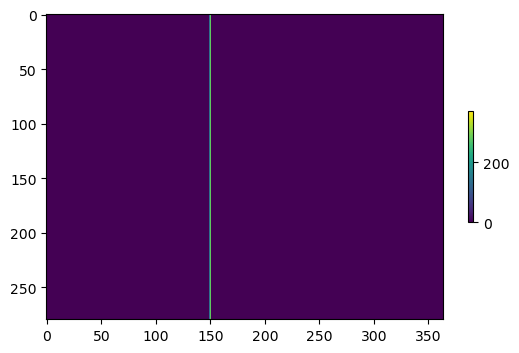

In [249]:
# validate the network
validator = cfpy.preprocessing.GeneralValidator(network=network, elevations=elevations)
valid_network = validator.validate_network()

""" generating the .nbr-file """
# we use the same layer elevations here as in the MODFLOW model

validator.generate_nbr(
    path = path,
    nrows = n_rows,
    ncols = n_cols,
    nlays = n_lays,
    nplanes = 1,
    layer_elevations = layer_elevations
)

# plot the network
# TODO Können wir hier das schöne Bild wie in EX_02 generieren?
im = plt.imshow(valid_network)
plt.colorbar(im, shrink=0.3)

#### Initialize nbr module

In [250]:
# NOTE: make sure there is only 1 .nbr-file in the active domain!!
# if no or multiple .nbr-files are present, CFPy throws an error

nbr = cfpy.nbr()

# read model layer/node and conduit layer/node elevations

# bot_elev has shape (n_layers, n_rows, n_cols)
# cond_elev has shape (n_conduit_layers, n_rows, n_cols)
# function looks for an .nbr-file, if none or more than one file is found, an error is raised
# make sure to only have one .nbr-file in the working directory
bot_elev, cond_elev = nbr.nbr_read()

# create nbr-data
nbr_data = nbr.nbr(bot_elev, cond_elev)

Elapsed time (.nbr file read): 0.07 s
Elapsed time (write nbr data): 0.3 s


In [251]:
# nbr-data contains:
#     0: node numbers
#     1: plane numbers
#     2: node locations
#     3: conduit locations
#     4: node neighbors
#     5: tube numbers
#     6: tube pairs
#     7: tube neighbors

# nbr data: locations in grid are indexed differently:
#     MODFLOW: (LAY, ROW, COL)
#     CFPy: (COL, ROW, LAY)

## Plot Network (Currently turned off to speed up troubleshooting

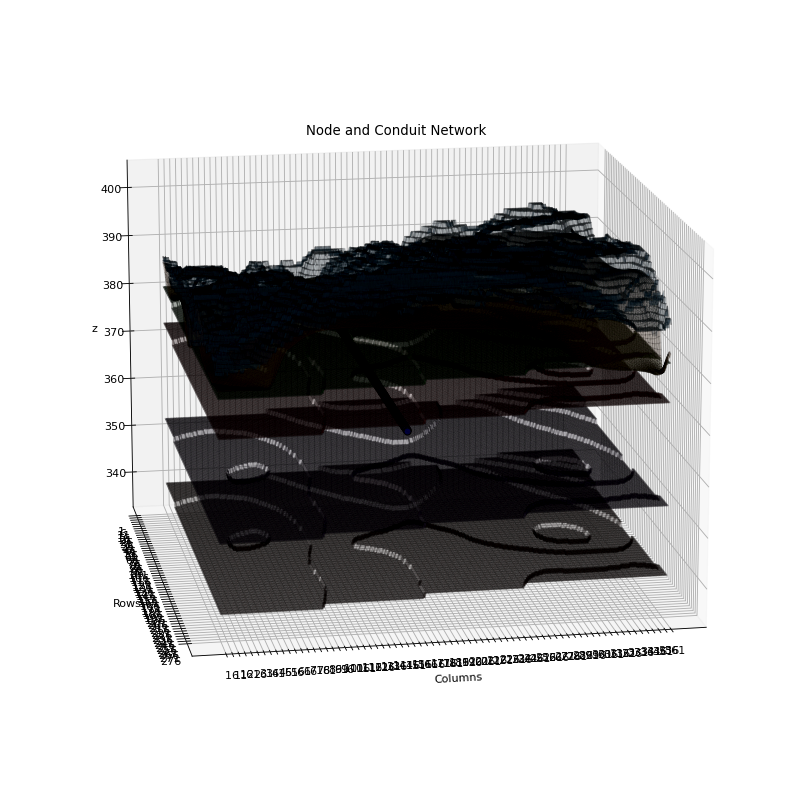

In [252]:
network = cfpy.plots.Network(elevs=[bot_elev, cond_elev], nbr_data=nbr_data)
plot = network.plot_network(text_shift=0.1, dpi=80, rot_x=15, rot_z=-100, plot_nums=False, kind="triangular")
plt.savefig("network.jpg", dpi=600)

In [253]:
%matplotlib inline

### CFPy parameterization of conduits/CFP Mode 1

In [254]:
## Make pipe parameterization lists

#get pipe numbers
p_num=nbr_data[5]

# parametrization of all k pipes
# assuming same characteristics for all pipes
# lists for all conduit parametrization can be accessed individually to make differently parametrized pipes
# e.g., p_diameter[13] = 0.45

# global parameters

DIA = 1.1
TOR = 1.5
KC  = 0.01
LRE = 500
HRE = 5000

# diameter
p_diameter = np.ones(len(p_num)) * DIA
p_diameter = p_diameter.tolist()

# tortuosity
p_tortuosity = np.ones(len(p_num)) * TOR
p_tortuosity = p_tortuosity.tolist()

# roughness height
p_rheight = np.ones(len(p_num)) * KC
p_rheight = p_rheight.tolist()

# lower critical reynolds number
p_lcritrey = np.ones(len(p_num)) * LRE
p_lcritrey = p_lcritrey.tolist()

# higher critical reynolds number
p_hcritrey = np.ones(len(p_num)) * HRE
p_hcritrey = p_hcritrey.tolist()

# summarize all data in a 2D-array
pipe_data = [p_num, p_diameter, p_tortuosity, p_rheight, p_lcritrey, p_hcritrey]

In [255]:
# make lists for node head boundary conditions and tube-matrix exchange parameters

# get node numbers
n_num = nbr_data[0]

# parametrization for all n nodes
# if head > 0: fixed head
# if head == -1: calculated head
n_head = np.ones((len(n_num))) * -1
n_head = n_head.tolist()

# set individual node boundary conditions here
# e.g., for n_head[-1] the last node has a constant head given by the variable node_head_bc
# and for n_head[0] the first node has a constant head
n_head[8] = node_head_bc

# conduit wall conductivity in [m/d]
# identical for all conduits
# create list containing individual values to parametrize conduits individually
kex = 12
k_exchange = np.ones((len(n_num))) * kex
k_exchange = k_exchange.tolist()

# summarize parametrization in lists
node_data = [n_num, n_head]
kex_data = [n_num, k_exchange]

### Initialzie the CFP Module

In [256]:
# if CADS should not be used or standard CFP (CFPv1) is used set cads = None below!

cfp = cfpy.cfp(mode = 1, # mode 1 == conduits, 2 == preferential flow layer (not supported), 3 == both (not supported)
               nnodes = len(n_num), 
               npipes = len(p_num), 
               nlay = n_lays, 
               nbr_data = nbr_data, 
               geoheight = cond_elev, 
               sa_exchange = 1, 
               epsilon = 0.000001,
               niter = 100, 
               relax = 1., 
               p_nr = 1., 
               cond_data = pipe_data, 
               n_head = node_data, 
               k_exchange = kex_data, 
               ncl = 0, 
               cl = 0, 
               ltemp = 25.,
               condl_data = 0,
               cads = None)

# create list of strings
cfp = cfp.cfp()

### CFPy - COC (Conduit output control)

In [257]:
""" initialize COC module """

coc = cfpy.coc(nnodes = len(nbr_data[0]),
               node_numbers = nbr_data[0],
               n_nts = 1,
               npipes = len(nbr_data[5]), 
               pipe_numbers = nbr_data[5],
               t_nts = 1)

# create list of strings
coc = coc.coc()

### CFPy = CRCH (conduit recharge)

In [258]:
# p_crch is list of length (n_nodes) specifying the direct recharge fraction for each node
# initially set p_crch to 0 for all nodes (no direct recharge)
p_crch = np.zeros((len(n_num))).tolist()

# input direct recharge fraction (0 <= p_crch <= 1) for individual nodes
p_crch[3] = 1.

crch = cfpy.crch(iflag_crch = 1, 
                 nper = n_pers, 
                 node_numbers = nbr_data[0], 
                 p_crch = p_crch)

# create list of strings
crch = crch.crch()

## MODFLOW Input Files (FloPy)

### DIS (Discretization to create model grid)

In [259]:
# Model grid:
# Note: MODFLOW defaults to units of m/day
# overall dimensions of domain (in x- and y-direction)
Lx = n_cols*delr
Ly = n_rows*delc
mtop = np.array(bot_elev[0][:][:])
mbot = np.array(bot_elev[1:][:][:])

# Create dis object:
dis = flopy.modflow.ModflowDis(mf, n_lays, n_rows, n_cols, n_pers, delr, delc, top=mtop, botm=mbot,
                               perlen=perlen, nstp=n_stps, steady=steady, itmuni=5, lenuni=2)

### BAS (Basic) Assigns conduit head boundaries

In [260]:
# if ibound < 0: constant head, if = 0: inactive, if > 0: active.
# create arrays to indicate active cells (ibound) and starting heads (H_init)
# integer array of dim (z,y,x), makes all cells active 
ibound = np.ones((n_lays, n_rows, n_cols), dtype=np.int32)
# replace leftmost and rightmost columns with -1 to indicate constant head 
#ibound[1,279,:] = -1 #turning off matrix constant head boundary

strt = np.full((n_lays, n_rows,n_cols), topm-3) #initial hydraulic head 3 m below the land surface

#make the last row the higher head value
#strt[1,279,:] = H_bot   #turning this final row head boundary off

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

### LPF (Layer Property Flow) :Horizontal and vertical flow params between cells

In [261]:
# Only one of either the BCF, LPF, or HUF2 packages should be used to control flow between cells
# Can also in this package set confined/unconfined (defaults to confined), cell-by-cell Ks as an array, 
# storage, specific yield, etc.
# defaults to confined

#0=confined, >0 = unconfined/convertible
laytyp = [2, 2, 2, 2, 2]

lpf = flopy.modflow.ModflowLpf(mf, laytyp=laytyp, hk=hk, vka=vka, ss=ss, sy=sy) 

### OC (Output Control) Decides what outputs to save

In [262]:
# create output control file using dictionary
oc = flopy.modflow.ModflowOc(mf)

### PCG (Preconditioned conjugate gradient

In [263]:
pcg = flopy.modflow.ModflowPcg(mf, mxiter=40, iter1=10, ihcofadd=9999, relax=0.97,npcond=2, nbpol=2, iprpcg=5, mutpcg=0, hclose=12000, rclose=10000)

### RCH (recharge)

In [264]:

# recharge flux distributed over the top of the model - MODFLOW multiplies the fluxes by the horizontal area of the cells 
# to which they are applied to calculate the volumetric flux rates

# generate recharge data
rch_ts = np.ones_like(topm) *.8669 #based on 34.13 inches of toal rainfall in 2022. Doesn't account for snowmelt, need to calculate


# flag, 1=rech only applied to top layer
nrchop = 1
# if non-zero, cell budget data will be saved
ipakcb = 50
# layer to which recharge is applied to (only used if nrchop=2)
irch = 1

# dictionary of recharge fluxes for each stress period
rech = {}
    
for num, rech_in in enumerate(rch_ts):
    
    # make array (n_rows x n_cols) to store cell-by-cell recharge information
    # apply recharge to all cells then apply direct recharge in relevant cells
    rech_data = np.ones((n_rows, n_cols)) * rech_in
    
    # direct recharge cells have to be given explicitly
    # such as
    # rech_data[ROW, COL] = some_direct_recharge
    
    rech[num] = rech_data

rch = flopy.modflow.mfrch.ModflowRch(mf, nrchop=nrchop, ipakcb=ipakcb, rech=rech, irch=irch)

## Visualize the matrix, starting heads, and hydraulic conductivity 

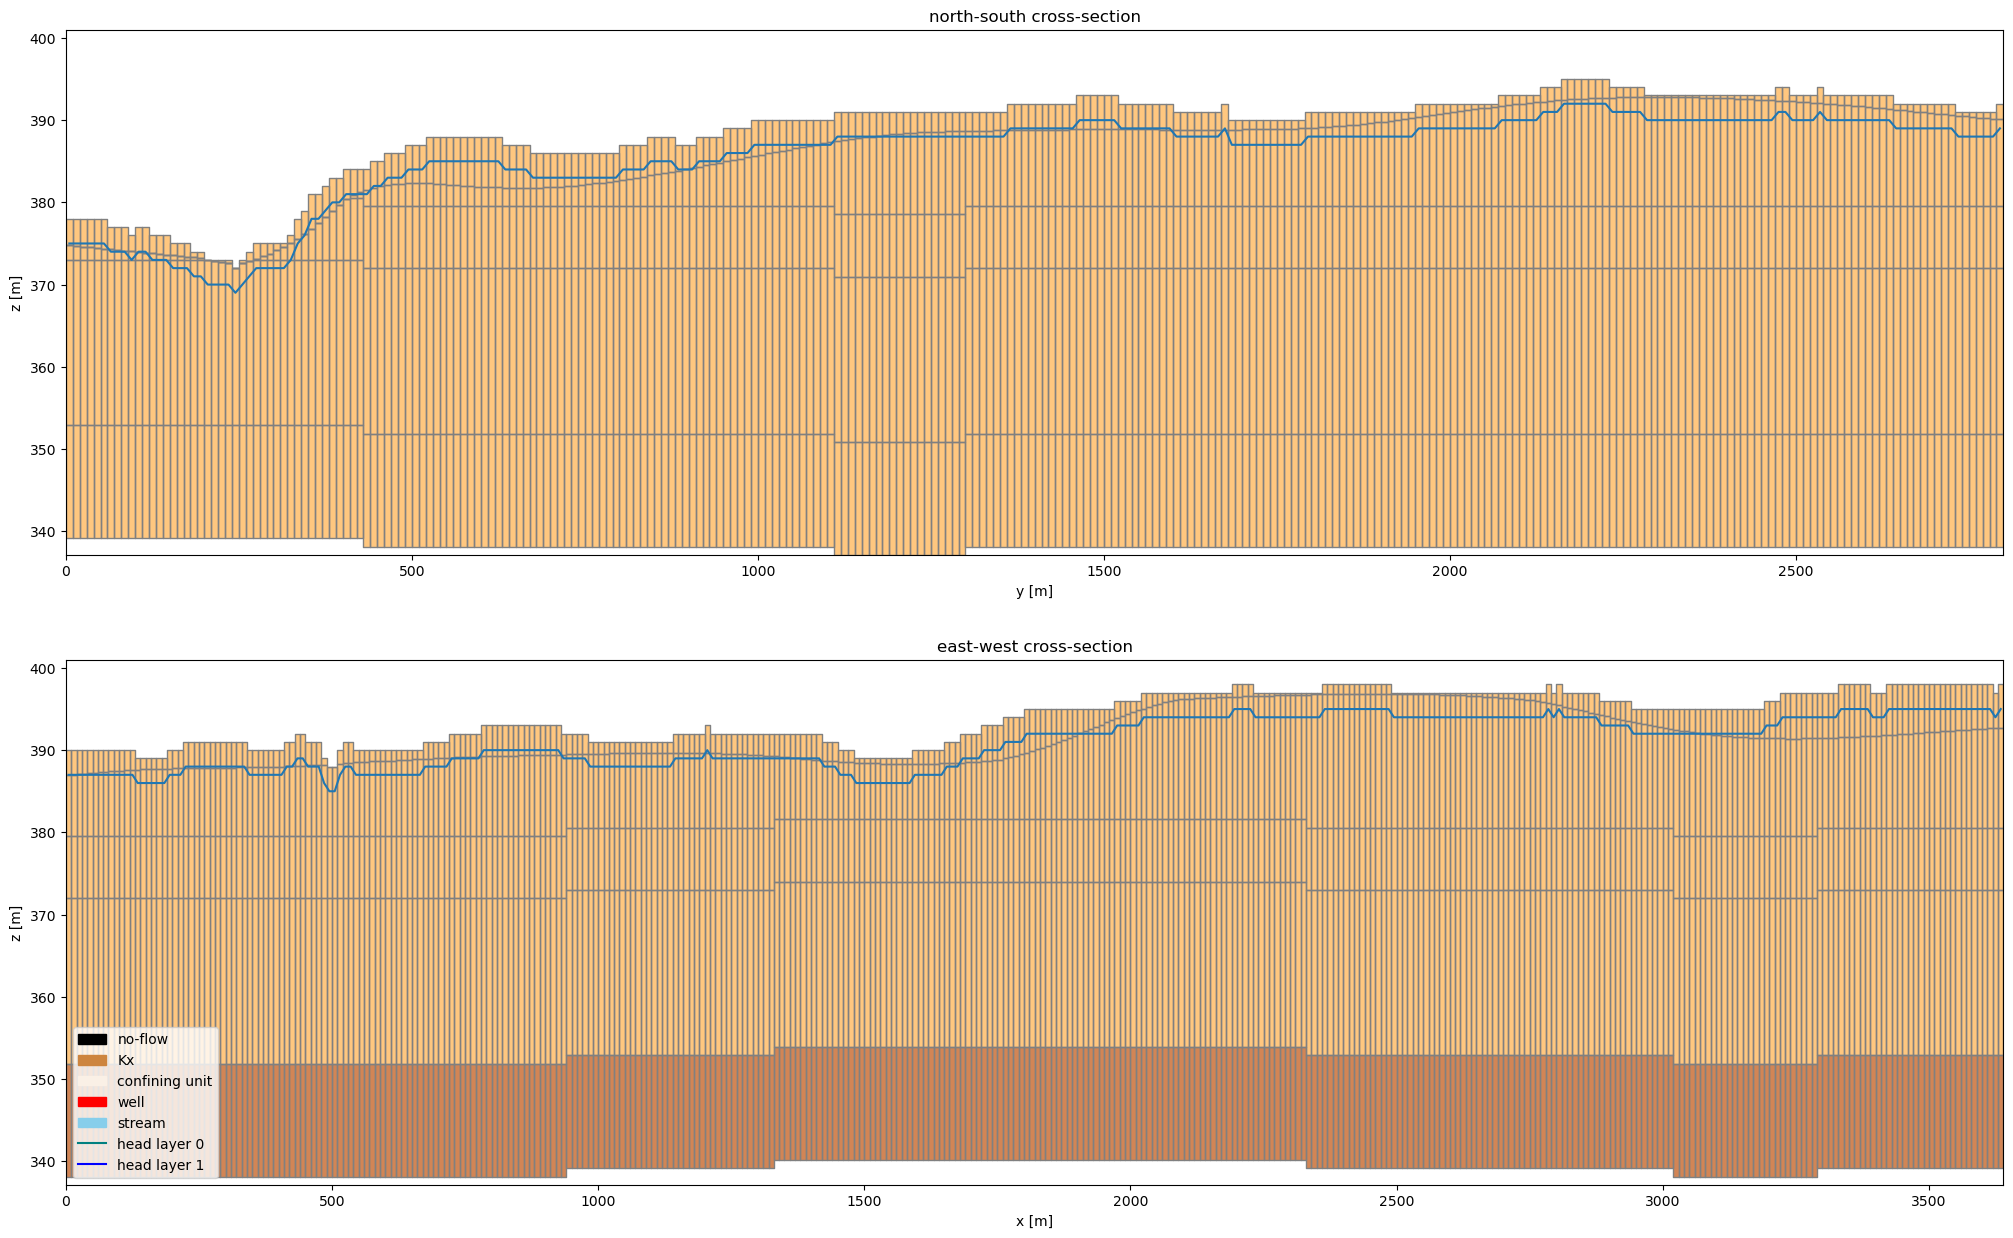

In [265]:
#Plot cross-section view of model:
row = 170     #row to plot on
col = 65      #column to plot on

#South-North:
f,ax = plt.subplots(2,1, figsize=(25,15))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'column': col})  #plot cross-section along given column (change column # to see different locations)
k  = xsec.plot_array(hk, cmap='copper', vmin=-10, vmax=100)                 #plot horizontal K as an array, with color range set manually to be consistent with other plots
ax[0].plot(np.arange(delr/2,Ly,delr), strt[0,:,col])                         #plots starting heads as a line
#ax[0].plot(np.arange(delr/2,Ly,delr), strt[1,:,col], color='blue')           #plots starting heads as a line
bc = xsec.plot_ibound()                                                      #plot boundary conditions
try: s  = xsec.plot_bc("STR", color='skyblue')                                    #plot stream
except: pass
try: w = xsec.plot_bc("WEL", color='red')                                         #plot wells (will only show wells at displayed column)
except: pass
try: g = m.plot_bc('GHB', color='goldenrod')                                      #plot head-dependent flow
except: pass
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('north-south cross-section')

#East-West:
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': row})    #plot cross-ection along stream row
k  = xsec.plot_array(hk, cmap='copper', vmin=-100, vmax=200)                #plot heads as an array, with color range set manually to be consistent with other plots
ax[1].plot(np.arange(delc/2,Lx,delc), strt[0,row,:])                        #plots starting heads as a line
#ax[1].plot(np.arange(delc/2,Lx,delc), strt[1,row,:], color='blue')          #plots starting heads as a line
bc = xsec.plot_ibound()                                                     #plot boundary conditions
try: s  = xsec.plot_bc("STR", color='skyblue')                                    #plot stream
except: pass
try: w = xsec.plot_bc("WEL", color='red')                                        #plot wells (will only show wells at displayed row)
except: pass
try: g = m.plot_bc('GHB', color='goldenrod')                                     #plot head-dependent flow
except: pass
g  = xsec.plot_grid()                                                       #plot grid
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('east-west cross-section')

plt.legend(handles=[matplotlib.patches.Patch(color='black',label='no-flow'),
                    matplotlib.patches.Patch(color='peru',label='Kx'),
                    matplotlib.patches.Patch(color='linen',label='confining unit'),
                    matplotlib.patches.Patch(color='red',label='well'),
                    matplotlib.patches.Patch(color='skyblue',label='stream'),
                    matplotlib.lines.Line2D([],[], color='teal',label='head layer 0'),
                    matplotlib.lines.Line2D([],[], color='blue',label='head layer 1')]) #add legend manually

## Write input files and run the model

### MODFLOW Input

In [266]:
mf.write_input()

### CFP Mode 1 Input

#### CFPy, write_input

In [267]:
input_files = cfpy.write_input(modelname = modelname,
                               data_strings = [coc, crch, cfp],
                               file_extensions = ['coc', 'crch', 'cfp'])

# write CFP input files
input_files.write_input()

### CFPy update_nam

In [268]:
nam = cfpy.update_nam(modelname = modelname,
                      mode = 1,
                      cfp_unit_num = 52,
                      crch_unit_num = 53,
                      coc_unit_num = 54)

# update existing .nam file
nam.update_nam()

## Run MODFLOW 2005 CFP

In [269]:
success, buff = mf.run_model(silent=False)

FloPy is using the following executable to run the model: .\cfpv2.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                   Version 1.9.62 2019/09/16 CFPv2 HTM/STM/UMT-LNK/CADS
THIS IS A RESEARCH VERSION OF CFP MODE 1 FOR TEST PURPOSES WITHOUT ANY WARRANTY REGARDING CORRECTNESS
CONTACT: THOMAS.REIMANN@TU-DRESDEN.DE AND BSHOEMAK@USGS.GOV

 Using NAME file: BS_CFP_singleCond_v1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/04/12 15:31:32

 CFP FLOW STRESS PERIOD:     1 TIME STEP:     1
 RUN END DATE AND TIME (YYYY/MM/DD HH:MM:SS): 2023/04/12 15:31:41
 ELAPSED RUN TIME:  8.747 SECONDS

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA


## Post Processing

### Process the information for the MODFLOW Continuum

In [270]:
#Load the data
import flopy.utils.binaryfile as bf

# get cell head information
# choose location to measure heads (lay,row,col), zero-based indexing
obs_loc = (0,1,2)

# read the list, binary files
lst = flopy.utils.MfListBudget(modelname+'.list')
hds = bf.HeadFile(modelname+'.hds')
# return a list of head and budget print times
h_times = hds.get_times()
b_times = lst.get_times()

heads = []
for t in h_times:
    heads.append(hds.get_data(totim=t))
heads = np.asarray(heads)

budgets = []
for t in b_times:
    budgets.append(lst.get_data(totim=t, incremental=True))

# get a time series of heads at a specific location
obs_ts = hds.get_ts(obs_loc)

### Process the information for CFP Mode1

In [271]:
fr = cfpy.postprocessing.FileReader(
    modelname=modelname
)

node_data, tube_data = [], []

node_nums = [1, 2, 5]
tube_nums = [1, 2, 4]

for node in node_nums:
    node_df, tube_df = fr.read_output(node_num=node, tube_num=None)
    node_data.append(node_df)
    
for tube in tube_nums:
    node_df, tube_df = fr.read_output(node_num=None, tube_num=tube)
    tube_data.append(tube_df)

In [272]:
## Lok at this imported node time series data
node_data[0].head()

,Node#,Node Head [L],Matrix Head [L],Exchange [L3 T-1],CADS Flow [L3 T-1],PFPS Flow [L3 T-1],Direct Recharge [L3 T-1],Q Well [L3 T-1],FHLQ,Cauchy,Cauchy LQ,QLH,Q Fix [L3 T-1]
1,372.0,385.0456,-3688.566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [273]:
## Look at the imported tube time series data
tube_data[0].head()

,Tube,Beginning Node#,Ending Node#,Flow Type,Q [L3 T-1],Diam. [L],Len. [L],Re [-],Residence Time [T]


## Generate Plots for Visualization (Turned off for troubleshooting)

In [274]:
## Generate more plots (spatially distributed information)
#network = cfpy.plots.Network(elevs=[bot_elev, cond_elev], nbr_data=nbr_data)
#plot = network.plot_results(heads=heads, time=0, layer=2, text_shift=0.1, dpi=100, rot_x=25, rot_z=120, plot_nums=False, n_contours=20, alpha=0.01)
#plt.savefig("results_network.png", dpi=600)

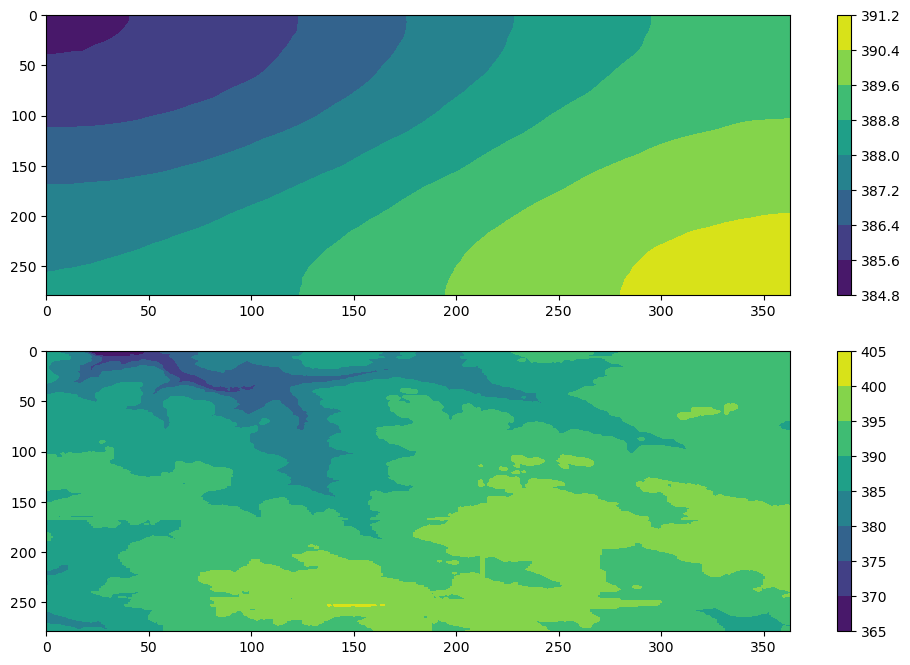

In [275]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

im = ax1.contourf(heads[0,4,:,:])
ax1.invert_yaxis()
fig.colorbar(mappable=im)

topo = ax2.contourf(topm)
ax2.invert_yaxis()
fig.colorbar(mappable=topo)